## Análisis y predicción del consumo energético en Europa


### Introducción

En este proyecto analizamos los patrones de consumo energético en Europa y construimos un modelo predictivo para estimar el consumo futuro.
Utilizamos datos abiertos y técnicas avanzadas de análisis y modelado.

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

Carga y preparación de datos

In [38]:
data_path = "data/time_series_60min_singleindex.csv"
df = pd.read_csv(data_path, parse_dates=['utc_timestamp'], index_col='utc_timestamp')

In [39]:
df.head(10)

,cet_cest_timestamp,AT_load_actual_entsoe_transparency,AT_load_forecast_entsoe_transparency,AT_price_day_ahead,AT_solar_generation_actual,AT_wind_onshore_generation_actual,BE_load_actual_entsoe_transparency,BE_load_forecast_entsoe_transparency,BE_solar_generation_actual,BE_wind_generation_actual,...,SI_load_actual_entsoe_transparency,SI_load_forecast_entsoe_transparency,SI_solar_generation_actual,SI_wind_onshore_generation_actual,SK_load_actual_entsoe_transparency,SK_load_forecast_entsoe_transparency,SK_solar_generation_actual,SK_wind_onshore_generation_actual,UA_load_actual_entsoe_transparency,UA_load_forecast_entsoe_transparency
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,2015-01-01T00:00:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 00:00:00+00:00,2015-01-01T01:00:00+0100,5946.0,6701.0,35.0,NaN,69.0,9484.0,9897.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 01:00:00+00:00,2015-01-01T02:00:00+0100,5726.0,6593.0,45.0,NaN,64.0,9152.0,9521.0,NaN,734.81,...,1045.47,816.0,NaN,1.17,2728.0,2860.0,3.8,NaN,NaN,NaN
2015-01-01 02:00:00+00:00,2015-01-01T03:00:00+0100,5347.0,6482.0,41.0,NaN,65.0,8799.0,9135.0,NaN,766.64,...,1004.79,805.0,NaN,1.04,2626.0,2810.0,3.8,NaN,NaN,NaN
2015-01-01 03:00:00+00:00,2015-01-01T04:00:00+0100,5249.0,6454.0,38.0,NaN,64.0,8567.0,8909.0,NaN,733.13,...,983.79,803.0,NaN,1.61,2618.0,2780.0,3.8,NaN,NaN,NaN
2015-01-01 04:00:00+00:00,2015-01-01T05:00:00+0100,5309.0,6609.0,35.0,NaN,64.0,8487.0,8806.0,NaN,730.99,...,998.67,824.0,NaN,1.60,2626.0,2790.0,3.8,NaN,NaN,NaN
2015-01-01 05:00:00+00:00,2015-01-01T06:00:00+0100,5574.0,6543.0,35.0,NaN,84.0,8428.0,8805.0,NaN,820.66,...,1045.17,886.0,NaN,0.00,2641.0,2830.0,3.8,NaN,NaN,NaN
2015-01-01 06:00:00+00:00,2015-01-01T07:00:00+0100,5925.0,6851.0,36.0,NaN,131.0,8122.0,8651.0,NaN,940.12,...,1085.06,985.0,NaN,0.00,2622.0,2790.0,3.8,NaN,NaN,NaN
2015-01-01 07:00:00+00:00,2015-01-01T08:00:00+0100,6343.0,7061.0,36.0,2.0,109.0,8179.0,8674.0,NaN,1087.66,...,1142.36,1109.0,NaN,0.00,2691.0,2980.0,3.9,NaN,NaN,NaN


In [40]:
df.columns.tolist()

['cet_cest_timestamp',
 'AT_load_actual_entsoe_transparency',
 'AT_load_forecast_entsoe_transparency',
 'AT_price_day_ahead',
 'AT_solar_generation_actual',
 'AT_wind_onshore_generation_actual',
 'BE_load_actual_entsoe_transparency',
 'BE_load_forecast_entsoe_transparency',
 'BE_solar_generation_actual',
 'BE_wind_generation_actual',
 'BE_wind_offshore_generation_actual',
 'BE_wind_onshore_generation_actual',
 'BG_load_actual_entsoe_transparency',
 'BG_load_forecast_entsoe_transparency',
 'BG_solar_generation_actual',
 'BG_wind_onshore_generation_actual',
 'CH_load_actual_entsoe_transparency',
 'CH_load_forecast_entsoe_transparency',
 'CH_solar_capacity',
 'CH_solar_generation_actual',
 'CH_wind_onshore_capacity',
 'CH_wind_onshore_generation_actual',
 'CY_load_actual_entsoe_transparency',
 'CY_load_forecast_entsoe_transparency',
 'CY_wind_onshore_generation_actual',
 'CZ_load_actual_entsoe_transparency',
 'CZ_load_forecast_entsoe_transparency',
 'CZ_solar_generation_actual',
 'CZ_wind

### Análisis Exploratorio de Datos (EDA)

Filtramos las columnas de interés: Consumo total y consumo total por región

In [41]:
filtered_columns = [col for col in df.columns if "_load_actual_entsoe_transparency" in col]


In [42]:
if len(filtered_columns) == 0:
    print("No se encontraron columnas relacionadas con el consumo energético. Verifica el dataset.")
else:
    print(f"Columnas seleccionadas: {filtered_columns}")


Columnas seleccionadas: ['AT_load_actual_entsoe_transparency', 'BE_load_actual_entsoe_transparency', 'BG_load_actual_entsoe_transparency', 'CH_load_actual_entsoe_transparency', 'CY_load_actual_entsoe_transparency', 'CZ_load_actual_entsoe_transparency', 'DE_load_actual_entsoe_transparency', 'DE_50hertz_load_actual_entsoe_transparency', 'DE_LU_load_actual_entsoe_transparency', 'DE_amprion_load_actual_entsoe_transparency', 'DE_tennet_load_actual_entsoe_transparency', 'DE_transnetbw_load_actual_entsoe_transparency', 'DK_load_actual_entsoe_transparency', 'DK_1_load_actual_entsoe_transparency', 'DK_2_load_actual_entsoe_transparency', 'EE_load_actual_entsoe_transparency', 'ES_load_actual_entsoe_transparency', 'FI_load_actual_entsoe_transparency', 'FR_load_actual_entsoe_transparency', 'GB_GBN_load_actual_entsoe_transparency', 'GB_NIR_load_actual_entsoe_transparency', 'GB_UKM_load_actual_entsoe_transparency', 'GR_load_actual_entsoe_transparency', 'HR_load_actual_entsoe_transparency', 'HU_load_a

In [43]:
edf = df[filtered_columns]
edf.head(10)

,AT_load_actual_entsoe_transparency,BE_load_actual_entsoe_transparency,BG_load_actual_entsoe_transparency,CH_load_actual_entsoe_transparency,CY_load_actual_entsoe_transparency,CZ_load_actual_entsoe_transparency,DE_load_actual_entsoe_transparency,DE_50hertz_load_actual_entsoe_transparency,DE_LU_load_actual_entsoe_transparency,DE_amprion_load_actual_entsoe_transparency,...,RO_load_actual_entsoe_transparency,RS_load_actual_entsoe_transparency,SE_load_actual_entsoe_transparency,SE_1_load_actual_entsoe_transparency,SE_2_load_actual_entsoe_transparency,SE_3_load_actual_entsoe_transparency,SE_4_load_actual_entsoe_transparency,SI_load_actual_entsoe_transparency,SK_load_actual_entsoe_transparency,UA_load_actual_entsoe_transparency
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 00:00:00+00:00,5946.0,9484.0,NaN,NaN,NaN,NaN,41151.0,6839.0,NaN,15163.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 01:00:00+00:00,5726.0,9152.0,4585.0,7640.14,NaN,5957.57,40135.0,6955.0,NaN,14826.0,...,NaN,NaN,14485.0,1092.0,1835.0,9277.0,2281.0,1045.47,2728.0,NaN
2015-01-01 02:00:00+00:00,5347.0,8799.0,4440.0,7391.44,NaN,5878.87,39106.0,7094.0,NaN,14405.0,...,NaN,NaN,14298.0,1059.0,1794.0,9132.0,2313.0,1004.79,2626.0,NaN
2015-01-01 03:00:00+00:00,5249.0,8567.0,4418.0,7332.57,NaN,5827.80,38765.0,7364.0,NaN,14083.0,...,NaN,NaN,14249.0,1019.0,1775.0,9083.0,2372.0,983.79,2618.0,NaN
2015-01-01 04:00:00+00:00,5309.0,8487.0,4393.0,7002.08,NaN,5730.89,38941.0,7992.0,NaN,13810.0,...,NaN,NaN,14268.0,990.0,1752.0,9102.0,2424.0,998.67,2626.0,NaN
2015-01-01 05:00:00+00:00,5574.0,8428.0,4441.0,7043.26,NaN,5668.53,39045.0,9104.0,NaN,13396.0,...,NaN,NaN,14655.0,1045.0,1862.0,9353.0,2395.0,1045.17,2641.0,NaN
2015-01-01 06:00:00+00:00,5925.0,8122.0,4637.0,6836.73,NaN,5600.76,40206.0,10218.0,NaN,13312.0,...,NaN,NaN,14994.0,1066.0,1872.0,9567.0,2489.0,1085.06,2622.0,NaN
2015-01-01 07:00:00+00:00,6343.0,8179.0,4834.0,6616.56,NaN,5651.05,41133.0,10685.0,NaN,13583.0,...,NaN,NaN,15163.0,1033.0,1908.0,9629.0,2593.0,1142.36,2691.0,NaN


In [44]:
def null_percentage(series):
    return (series.isnull().sum() / len(series)) * 100

In [45]:
nulls = edf.apply(null_percentage)
print("Porcentaje de valores nulos por columna:")
print(nulls)

Porcentaje de valores nulos por columna:
AT_load_actual_entsoe_transparency                0.001984
BE_load_actual_entsoe_transparency                0.001984
BG_load_actual_entsoe_transparency                0.128966
CH_load_actual_entsoe_transparency                0.005952
CY_load_actual_entsoe_transparency               34.662011
CZ_load_actual_entsoe_transparency                0.218250
DE_load_actual_entsoe_transparency                0.001984
DE_50hertz_load_actual_entsoe_transparency        0.001984
DE_LU_load_actual_entsoe_transparency            65.230849
DE_amprion_load_actual_entsoe_transparency        0.001984
DE_tennet_load_actual_entsoe_transparency         0.001984
DE_transnetbw_load_actual_entsoe_transparency     0.001984
DK_load_actual_entsoe_transparency                0.005952
DK_1_load_actual_entsoe_transparency              0.005952
DK_2_load_actual_entsoe_transparency              0.005952
EE_load_actual_entsoe_transparency                0.164679
ES_load_actual_

Vemos los valores nulos que hay en cada columna.

In [46]:
columns_with_nulls = nulls[nulls > 0].index.tolist()
if columns_with_nulls:
    print(f"Columnas con valores nulos: {columns_with_nulls}")
    print(edf[columns_with_nulls].isnull().sum())
else:
    print("No hay valores nulos significativos en las columnas seleccionadas.")

Columnas con valores nulos: ['AT_load_actual_entsoe_transparency', 'BE_load_actual_entsoe_transparency', 'BG_load_actual_entsoe_transparency', 'CH_load_actual_entsoe_transparency', 'CY_load_actual_entsoe_transparency', 'CZ_load_actual_entsoe_transparency', 'DE_load_actual_entsoe_transparency', 'DE_50hertz_load_actual_entsoe_transparency', 'DE_LU_load_actual_entsoe_transparency', 'DE_amprion_load_actual_entsoe_transparency', 'DE_tennet_load_actual_entsoe_transparency', 'DE_transnetbw_load_actual_entsoe_transparency', 'DK_load_actual_entsoe_transparency', 'DK_1_load_actual_entsoe_transparency', 'DK_2_load_actual_entsoe_transparency', 'EE_load_actual_entsoe_transparency', 'ES_load_actual_entsoe_transparency', 'FI_load_actual_entsoe_transparency', 'FR_load_actual_entsoe_transparency', 'GB_GBN_load_actual_entsoe_transparency', 'GB_NIR_load_actual_entsoe_transparency', 'GB_UKM_load_actual_entsoe_transparency', 'GR_load_actual_entsoe_transparency', 'HR_load_actual_entsoe_transparency', 'HU_lo

Rellenamos valores nulos.

In [47]:
edf = edf.ffill().bfill()

In [48]:
edf.head(10)

,AT_load_actual_entsoe_transparency,BE_load_actual_entsoe_transparency,BG_load_actual_entsoe_transparency,CH_load_actual_entsoe_transparency,CY_load_actual_entsoe_transparency,CZ_load_actual_entsoe_transparency,DE_load_actual_entsoe_transparency,DE_50hertz_load_actual_entsoe_transparency,DE_LU_load_actual_entsoe_transparency,DE_amprion_load_actual_entsoe_transparency,...,RO_load_actual_entsoe_transparency,RS_load_actual_entsoe_transparency,SE_load_actual_entsoe_transparency,SE_1_load_actual_entsoe_transparency,SE_2_load_actual_entsoe_transparency,SE_3_load_actual_entsoe_transparency,SE_4_load_actual_entsoe_transparency,SI_load_actual_entsoe_transparency,SK_load_actual_entsoe_transparency,UA_load_actual_entsoe_transparency
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,5946.0,9484.0,4585.0,7640.14,478.0,5957.57,41151.0,6839.0,41874.0,15163.0,...,6626.95,5614.0,14485.0,1092.0,1835.0,9277.0,2281.0,1045.47,2728.0,13373.0
2015-01-01 00:00:00+00:00,5946.0,9484.0,4585.0,7640.14,478.0,5957.57,41151.0,6839.0,41874.0,15163.0,...,6626.95,5614.0,14485.0,1092.0,1835.0,9277.0,2281.0,1045.47,2728.0,13373.0
2015-01-01 01:00:00+00:00,5726.0,9152.0,4585.0,7640.14,478.0,5957.57,40135.0,6955.0,41874.0,14826.0,...,6626.95,5614.0,14485.0,1092.0,1835.0,9277.0,2281.0,1045.47,2728.0,13373.0
2015-01-01 02:00:00+00:00,5347.0,8799.0,4440.0,7391.44,478.0,5878.87,39106.0,7094.0,41874.0,14405.0,...,6626.95,5614.0,14298.0,1059.0,1794.0,9132.0,2313.0,1004.79,2626.0,13373.0
2015-01-01 03:00:00+00:00,5249.0,8567.0,4418.0,7332.57,478.0,5827.80,38765.0,7364.0,41874.0,14083.0,...,6626.95,5614.0,14249.0,1019.0,1775.0,9083.0,2372.0,983.79,2618.0,13373.0
2015-01-01 04:00:00+00:00,5309.0,8487.0,4393.0,7002.08,478.0,5730.89,38941.0,7992.0,41874.0,13810.0,...,6626.95,5614.0,14268.0,990.0,1752.0,9102.0,2424.0,998.67,2626.0,13373.0
2015-01-01 05:00:00+00:00,5574.0,8428.0,4441.0,7043.26,478.0,5668.53,39045.0,9104.0,41874.0,13396.0,...,6626.95,5614.0,14655.0,1045.0,1862.0,9353.0,2395.0,1045.17,2641.0,13373.0
2015-01-01 06:00:00+00:00,5925.0,8122.0,4637.0,6836.73,478.0,5600.76,40206.0,10218.0,41874.0,13312.0,...,6626.95,5614.0,14994.0,1066.0,1872.0,9567.0,2489.0,1085.06,2622.0,13373.0
2015-01-01 07:00:00+00:00,6343.0,8179.0,4834.0,6616.56,478.0,5651.05,41133.0,10685.0,41874.0,13583.0,...,6626.95,5614.0,15163.0,1033.0,1908.0,9629.0,2593.0,1142.36,2691.0,13373.0


Mostramos los valores en la gráfica:

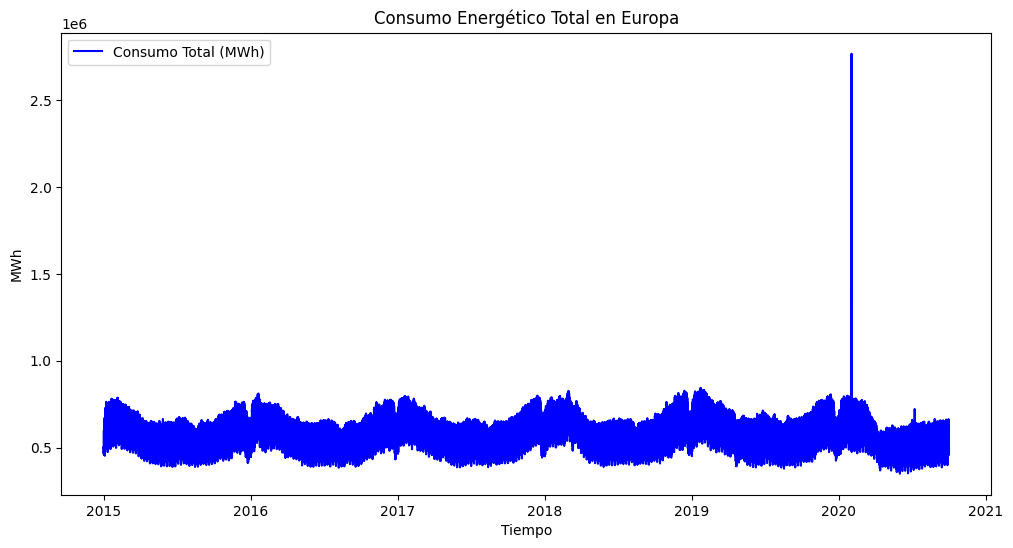

In [49]:
total_consumption = edf.sum(axis=1)
plt.figure(figsize=(12, 6))
plt.plot(total_consumption, label='Consumo Total (MWh)', color='blue')
plt.title("Consumo Energético Total en Europa")
plt.xlabel("Tiempo")
plt.ylabel("MWh")
plt.legend()
plt.show()

Observamos un outlier en el año 2020, así que vamos a corregirlo.

In [50]:
# Calculamos el percentil 99 para detectar outliers
upper_limit = edf.quantile(0.99)

# Aplicar el límite superior correctamente a cada columna
for col in edf.columns:
    edf[col] = np.where(edf[col] > upper_limit[col], upper_limit[col], edf[col])

print("Valores atípicos han sido corregidos usando el percentil 99.")

Valores atípicos han sido corregidos usando el percentil 99.


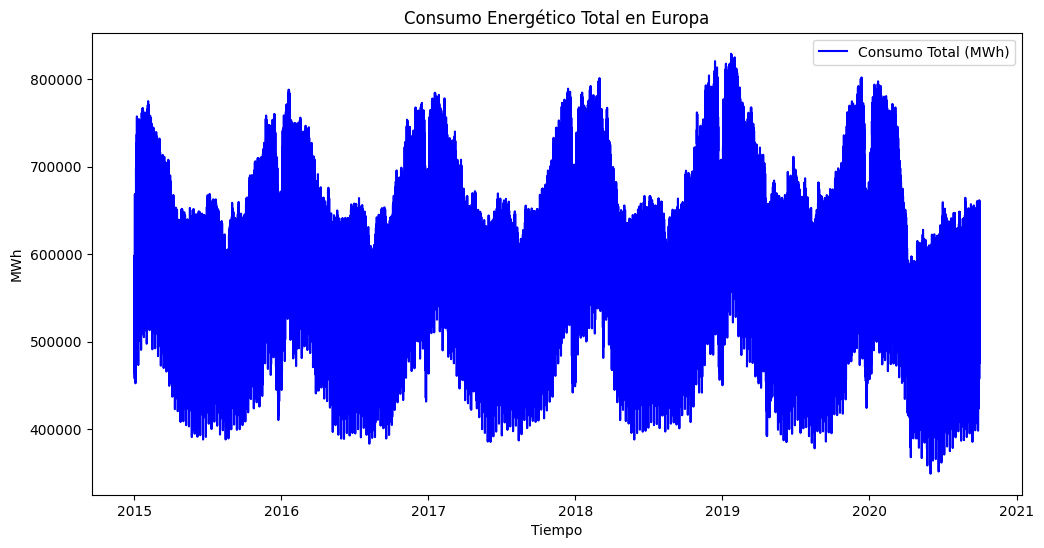

In [51]:
total_consumption = edf.sum(axis=1)
plt.figure(figsize=(12, 6))
plt.plot(total_consumption, label='Consumo Total (MWh)', color='blue')
plt.title("Consumo Energético Total en Europa")
plt.xlabel("Tiempo")
plt.ylabel("MWh")
plt.legend()
plt.show()

Observamos que se nos disparan los valores de MWh, por lo que lo corregimos:

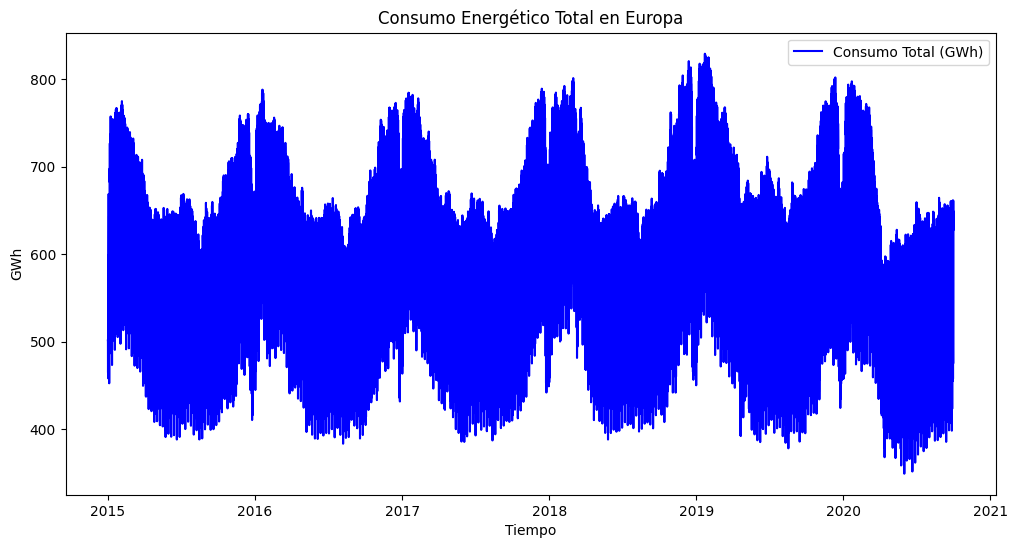

In [52]:
total_consumption = edf.sum(axis=1) / 1000  # Convertir de MWh a GWh
plt.figure(figsize=(12, 6))
plt.plot(total_consumption, label='Consumo Total (GWh)', color='blue')
plt.title("Consumo Energético Total en Europa")
plt.xlabel("Tiempo")
plt.ylabel("GWh")
plt.legend()
plt.show()

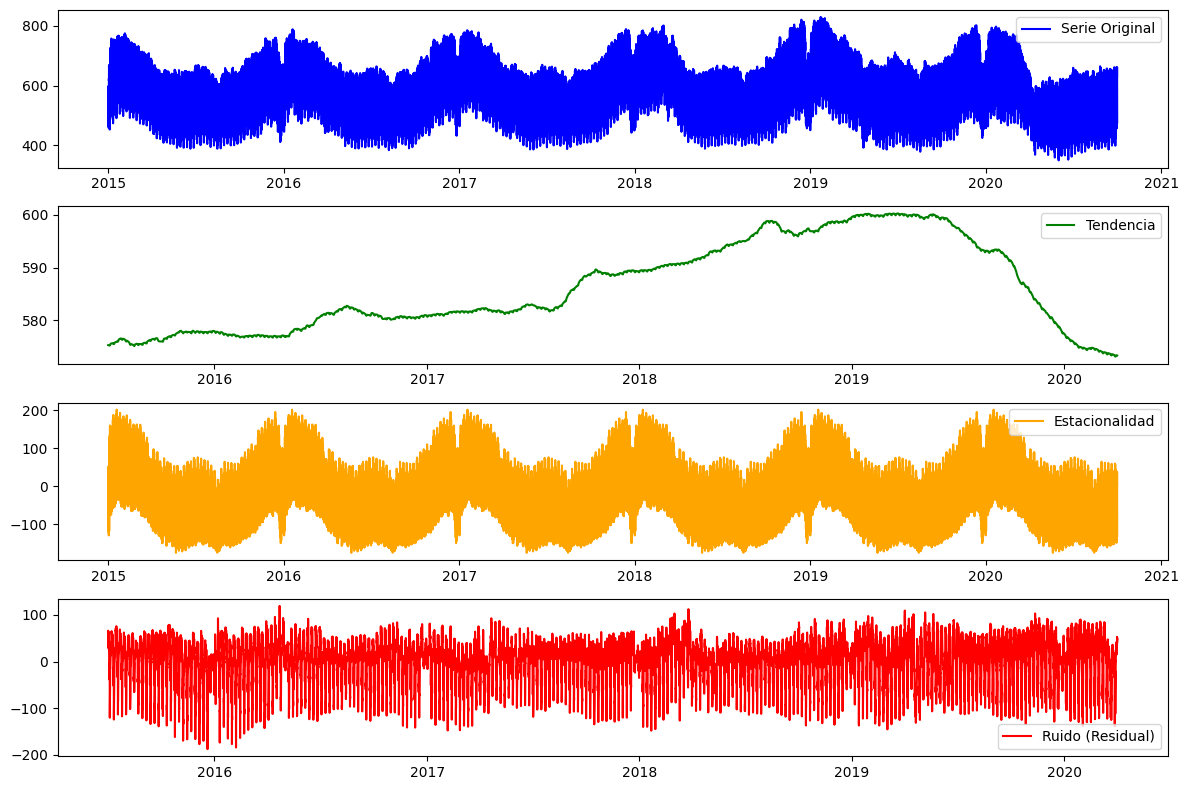

In [53]:
result = seasonal_decompose(total_consumption, model='additive', period=365*24)  # Periodo anual en horas
    
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(total_consumption, label='Serie Original', color='blue')
plt.legend()
    
plt.subplot(412)
plt.plot(result.trend, label='Tendencia', color='green')
plt.legend()
    
plt.subplot(413)
plt.plot(result.seasonal, label='Estacionalidad', color='orange')
plt.legend()
    
plt.subplot(414)
plt.plot(result.resid, label='Ruido (Residual)', color='red')
plt.legend()
    
plt.tight_layout()
plt.show()



1️⃣ Serie original (gráfico azul):

Refleja el consumo total de energía en GWh.
Se observan claramente las fluctuaciones estacionales anuales.

2️⃣ Tendencia (gráfico verde):

Muestra un crecimiento del consumo entre 2015 y 2019, alcanzando su punto máximo en 2019.
A partir de 2020, la tendencia desciende, posiblemente debido a eventos como la pandemia de COVID-19 o cambios en la demanda energética.

3️⃣ Estacionalidad (gráfico naranja):

Se observan patrones cíclicos bien definidos cada año.
El consumo parece ser más alto en invierno y más bajo en verano, lo que es consistente con un mayor uso de calefacción en los meses fríos.

4️⃣ Ruido (gráfico rojo):

Captura variaciones no explicadas por la tendencia ni la estacionalidad.
Se observan fluctuaciones más pronunciadas en algunos periodos, lo que podría deberse a eventos extraordinarios o datos atípicos.

### Modelado predictivo

Preparamos los datos.

In [54]:
df_ml = total_consumption.to_frame().reset_index()
df_ml.columns = ['ds', 'y']  # Renombrar columnas para consistencia
df_ml['ds'] = pd.to_datetime(df_ml['ds'])  # Asegurar que 'ds' sea datetime

Creamos características temporales:

In [55]:
df_ml['year'] = df_ml['ds'].dt.year
df_ml['month'] = df_ml['ds'].dt.month
df_ml['day'] = df_ml['ds'].dt.day
df_ml['dayofweek'] = df_ml['ds'].dt.dayofweek

Agregamos lag features (valores pasados)

In [56]:
df_ml['lag_1'] = df_ml['y'].shift(1)
df_ml['lag_7'] = df_ml['y'].shift(7)  # Semana anterior
df_ml['lag_30'] = df_ml['y'].shift(30)  # Mes anterior

Agregamos media movil.

In [57]:
df_ml['rolling_mean_7'] = df_ml['y'].rolling(window=7).mean()
df_ml['rolling_mean_30'] = df_ml['y'].rolling(window=30).mean()

Eliminamos valores nulos.

In [58]:
df_ml.dropna(inplace=True)

In [59]:
X = df_ml[['year', 'month', 'day', 'dayofweek', 'lag_1', 'lag_7', 'lag_30', 'rolling_mean_7', 'rolling_mean_30']]
y = df_ml['y']

# Dividir en conjunto de entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

Entrenamos los modelos:

In [60]:
# Modelo XGBoost
model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1)
model_xgb.fit(X_train, y_train)

# Modelo Random Forest
model_rf = RandomForestRegressor(n_estimators=100)
model_rf.fit(X_train, y_train)

RandomForestRegressor()

Predicciones:

In [61]:
y_pred_xgb = model_xgb.predict(X_test)
y_pred_rf = model_rf.predict(X_test)

Evaluamos los modelos.

In [62]:
# ---- EVALUAR MODELOS ----
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print(f"XGBoost - RMSE: {rmse_xgb:.2f}, MAE: {mae_xgb:.2f}")
print(f"Random Forest - RMSE: {rmse_rf:.2f}, MAE: {mae_rf:.2f}")

XGBoost - RMSE: 11.04, MAE: 7.75
Random Forest - RMSE: 10.30, MAE: 6.89


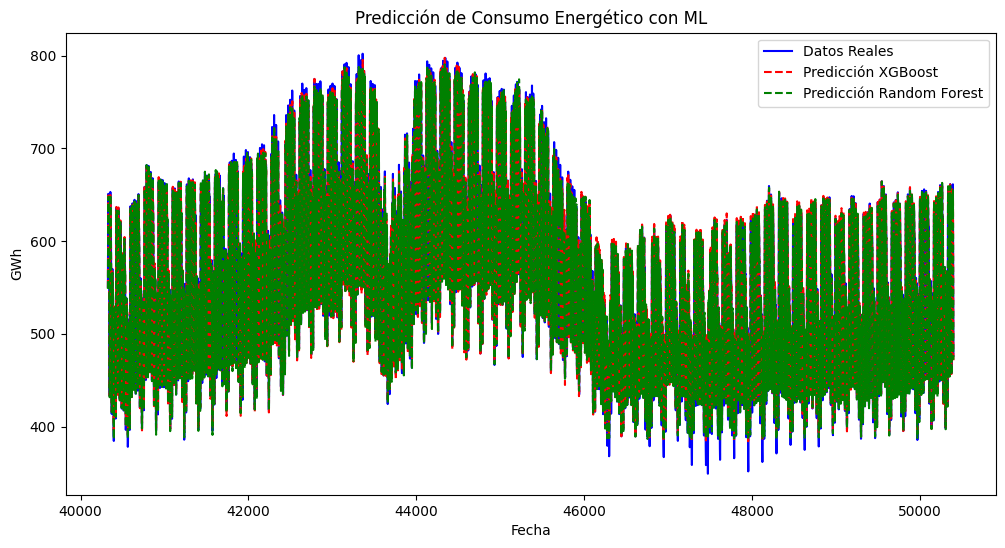

In [63]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Datos Reales', color='blue')
plt.plot(y_test.index, y_pred_xgb, label='Predicción XGBoost', color='red', linestyle='dashed')
plt.plot(y_test.index, y_pred_rf, label='Predicción Random Forest', color='green', linestyle='dashed')
plt.title("Predicción de Consumo Energético con ML")
plt.xlabel("Fecha")
plt.ylabel("GWh")
plt.legend()
plt.show()

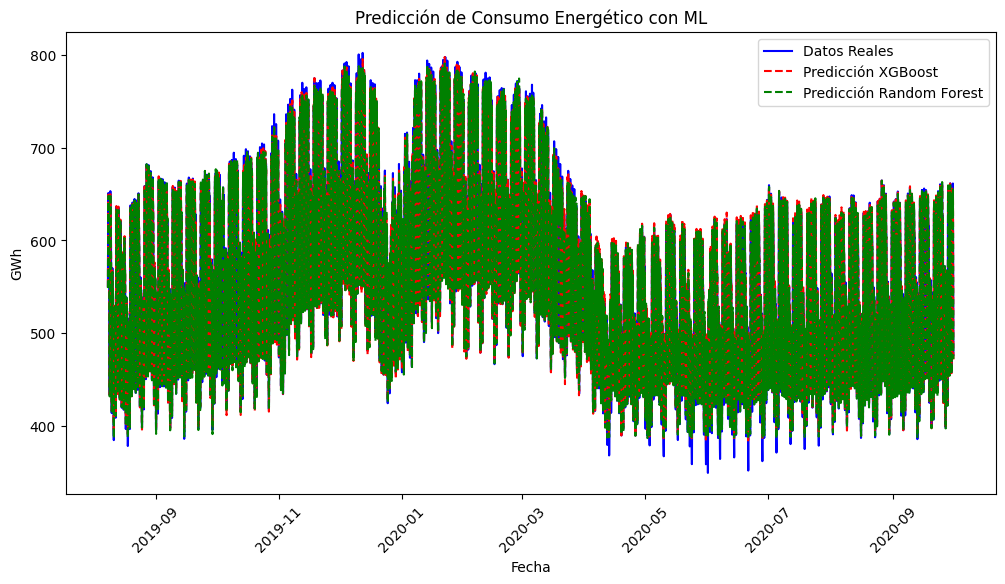

In [64]:
plt.figure(figsize=(12, 6))

# Usar el índice de fechas correctas
plt.plot(df_ml['ds'].iloc[len(X_train):], y_test, label='Datos Reales', color='blue')
plt.plot(df_ml['ds'].iloc[len(X_train):], y_pred_xgb, label='Predicción XGBoost', color='red', linestyle='dashed')
plt.plot(df_ml['ds'].iloc[len(X_train):], y_pred_rf, label='Predicción Random Forest', color='green', linestyle='dashed')

plt.title("Predicción de Consumo Energético con ML")
plt.xlabel("Fecha")
plt.ylabel("GWh")
plt.xticks(rotation=45)  # Rotar etiquetas del eje X para mayor claridad
plt.legend()
plt.show()

Observamos que ambos modelos tienen resultados muy parecidos, pero el modelo Random Forest tiene menor error, por lo que nos centraremos en este. A continuación ajustaremos hiperparámetros y agregaremos más características para mejorar el modelo.

In [65]:
# Definir hiperparámetros para ajustar
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Búsqueda aleatoria de hiperparámetros
random_search_rf = RandomizedSearchCV(RandomForestRegressor(), param_distributions=param_grid_rf, n_iter=10, cv=3, verbose=2, n_jobs=-1)
random_search_rf.fit(X_train, y_train)

# Mejor modelo encontrado
best_rf = random_search_rf.best_estimator_

# Hacer predicciones con el mejor modelo
y_pred_best_rf = best_rf.predict(X_test)

# Evaluar modelo ajustado
rmse_best_rf = np.sqrt(mean_squared_error(y_test, y_pred_best_rf))
mae_best_rf = mean_absolute_error(y_test, y_pred_best_rf)

print(f"Mejor Random Forest - RMSE: {rmse_best_rf:.2f}, MAE: {mae_best_rf:.2f}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  49.0s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  49.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  30.8s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  48.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  31.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  30.3s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  48.8s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  48.7s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  22.8s
[CV] END max

Podemos observar que tenemos el Random Forest ajustado, ya que el error sale incluso mayor después de ajustar los hiperparámetros.

### Predicción del consumo energético futuro (365 días)

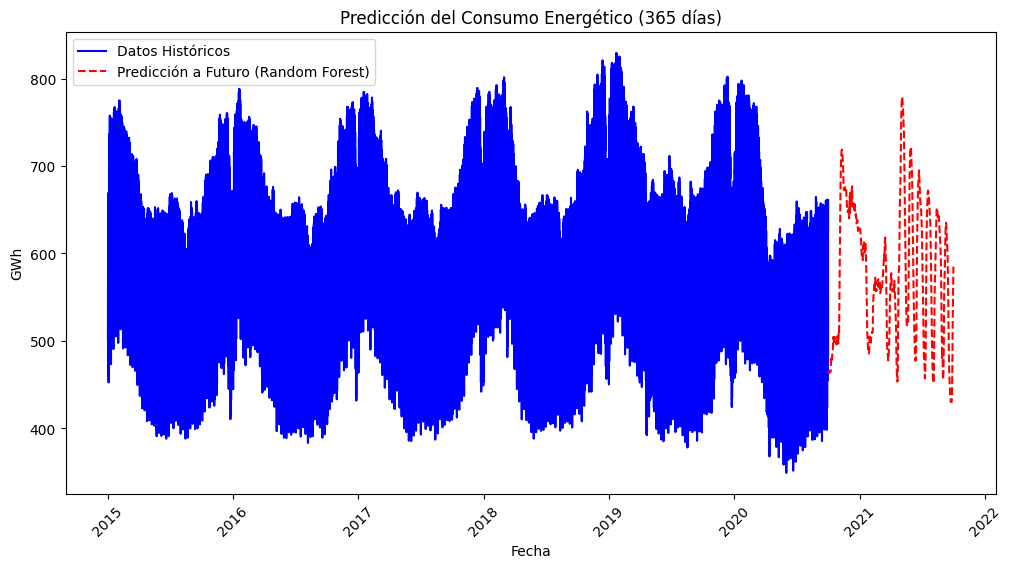

In [66]:
from datetime import timedelta

# Creamos fechas futuras (365 días)
future_dates = pd.DataFrame({'ds': pd.date_range(start=df_ml['ds'].max() + timedelta(days=1), periods=365, freq='D')})

# Inicializamos las características lag y rolling mean basadas en los últimos datos históricos
last_values = df_ml[['y']].set_index(df_ml['ds']).tail(30)

# Creamos listas para almacenar las características futuras y predicciones
future_predictions = []
lag_1_values = []
lag_7_values = []
lag_30_values = []
rolling_mean_7_values = []
rolling_mean_30_values = []

# Iteramos sobre las fechas futuras para calcular características
for i in range(365):
    # Calculamos valores lag
    if i == 0:
        lag_1 = last_values['y'].iloc[-1]  # Último valor histórico
        lag_7 = last_values['y'].iloc[-7]  # 7 días antes
        lag_30 = last_values['y'].iloc[0]  # 30 días antes
    else:
        lag_1 = future_predictions[i-1]  # Usar la predicción anterior
        lag_7 = future_predictions[i-7] if i >= 7 else last_values['y'].iloc[-7]  # Predicción o histórico
        lag_30 = future_predictions[i-30] if i >= 30 else last_values['y'].iloc[0]  # Predicción o histórico

    # Calculamos medias móviles basadas en predicciones anteriores
    rolling_mean_7 = np.mean(future_predictions[-7:]) if len(future_predictions) >= 7 else np.mean(last_values['y'][-7:])
    rolling_mean_30 = np.mean(future_predictions[-30:]) if len(future_predictions) >= 30 else np.mean(last_values['y'])

    # Guardamos valores lag y rolling means
    lag_1_values.append(lag_1)
    lag_7_values.append(lag_7)
    lag_30_values.append(lag_30)
    rolling_mean_7_values.append(rolling_mean_7)
    rolling_mean_30_values.append(rolling_mean_30)

    # Creamos un DataFrame temporal para hacer la predicción
    temp_features = pd.DataFrame({
        'year': [future_dates['ds'].dt.year.iloc[i]],
        'month': [future_dates['ds'].dt.month.iloc[i]],
        'day': [future_dates['ds'].dt.day.iloc[i]],
        'dayofweek': [future_dates['ds'].dt.dayofweek.iloc[i]],
        'lag_1': [lag_1],
        'lag_7': [lag_7],
        'lag_30': [lag_30],
        'rolling_mean_7': [rolling_mean_7],
        'rolling_mean_30': [rolling_mean_30]
    })

    # Hacemos predicción y la guardarmos
    future_pred = best_rf.predict(temp_features)[0]
    future_predictions.append(future_pred)

# ---- AGREGAMOS PREDICCIONES AL DATAFRAME ----
future_dates['prediction'] = future_predictions
future_dates['lag_1'] = lag_1_values
future_dates['lag_7'] = lag_7_values
future_dates['lag_30'] = lag_30_values
future_dates['rolling_mean_7'] = rolling_mean_7_values
future_dates['rolling_mean_30'] = rolling_mean_30_values

# ---- VISUALIZAMOS RESULTADOS ----
plt.figure(figsize=(12, 6))
plt.plot(df_ml['ds'], df_ml['y'], label="Datos Históricos", color="blue")
plt.plot(future_dates['ds'], future_dates['prediction'], label="Predicción a Futuro (Random Forest)", color="red", linestyle="dashed")
plt.title("Predicción del Consumo Energético (365 días)")
plt.xlabel("Fecha")
plt.ylabel("GWh")
plt.xticks(rotation=45)
plt.legend()
plt.show()


### Predicción del consumo energético en Europa hasta el año 2030

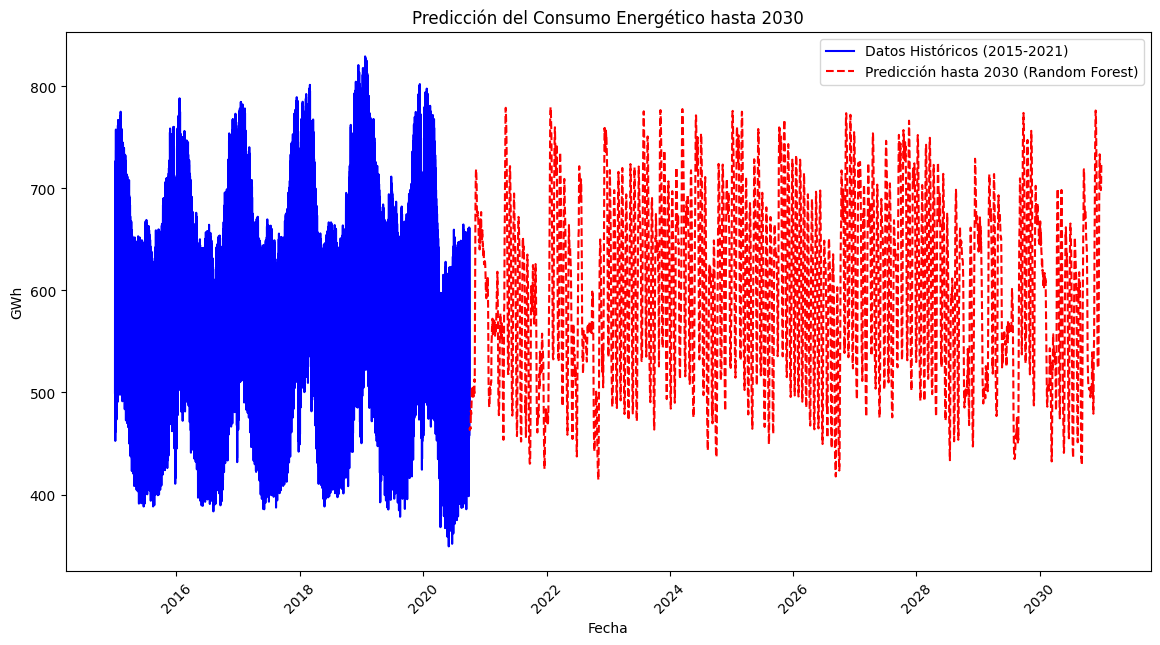

In [80]:
from datetime import timedelta

# ---- ELIMINAMOS ZONAS HORARIAS DEL ÍNDICE ----
df_ml.index = df_ml.index.tz_localize(None)  # Convertimos a timezone-naive

# Obtenemos la última fecha de los datos históricos
max_date = df_ml.index.max()

# ---- GENERAMOS FECHAS FUTURAS HASTA 2030 ----
num_days = (pd.to_datetime('2030-12-31') - max_date).days  # Número de días a predecir
future_dates = pd.DataFrame({'ds': pd.date_range(start=max_date + timedelta(days=1), periods=num_days, freq='D')})

# ---- INICIALIZAMOS VARIABLES ----
last_values = df_ml[['y']].tail(30)  # Últimos 30 valores históricos

future_predictions = []
lag_1_values, lag_7_values, lag_30_values = [], [], []
rolling_mean_7_values, rolling_mean_30_values = [], []

# ---- GENERAMOS PREDICCIONES PARA CADA DÍA FUTURO ----
for i in range(num_days):
    # Calcular valores lag
    if i == 0:
        lag_1 = last_values['y'].iloc[-1]  # Último valor histórico
        lag_7 = last_values['y'].iloc[-7]  # 7 días antes
        lag_30 = last_values['y'].iloc[0]  # 30 días antes
    else:
        lag_1 = future_predictions[i-1]  
        lag_7 = future_predictions[i-7] if i >= 7 else last_values['y'].iloc[-7]
        lag_30 = future_predictions[i-30] if i >= 30 else last_values['y'].iloc[0]

    # Calculamos medias móviles
    rolling_mean_7 = np.mean(future_predictions[-7:]) if len(future_predictions) >= 7 else np.mean(last_values['y'][-7:])
    rolling_mean_30 = np.mean(future_predictions[-30:]) if len(future_predictions) >= 30 else np.mean(last_values['y'])

    # Guardamos valores lag y rolling means
    lag_1_values.append(lag_1)
    lag_7_values.append(lag_7)
    lag_30_values.append(lag_30)
    rolling_mean_7_values.append(rolling_mean_7)
    rolling_mean_30_values.append(rolling_mean_30)

    # Creamos DataFrame temporal para hacer la predicción
    temp_features = pd.DataFrame({
        'year': [future_dates['ds'].dt.year.iloc[i]],
        'month': [future_dates['ds'].dt.month.iloc[i]],
        'day': [future_dates['ds'].dt.day.iloc[i]],
        'dayofweek': [future_dates['ds'].dt.dayofweek.iloc[i]],
        'lag_1': [lag_1],
        'lag_7': [lag_7],
        'lag_30': [lag_30],
        'rolling_mean_7': [rolling_mean_7],
        'rolling_mean_30': [rolling_mean_30]
    })

    # Hacemos predicción y guardarla
    future_pred = best_rf.predict(temp_features)[0]
    future_predictions.append(future_pred)

# ---- AGREGAMOS PREDICCIONES AL DATAFRAME ----
future_dates['prediction'] = future_predictions
future_dates['lag_1'] = lag_1_values
future_dates['lag_7'] = lag_7_values
future_dates['lag_30'] = lag_30_values
future_dates['rolling_mean_7'] = rolling_mean_7_values
future_dates['rolling_mean_30'] = rolling_mean_30_values

# ---- VISUALIZAMOS RESULTADOS ----
plt.figure(figsize=(14, 7))
plt.plot(df_ml.index, df_ml['y'], label="Datos Históricos (2015-2021)", color="blue")
plt.plot(future_dates['ds'], future_dates['prediction'], label="Predicción hasta 2030 (Random Forest)", color="red", linestyle="dashed")

plt.title("Predicción del Consumo Energético hasta 2030")
plt.xlabel("Fecha")
plt.ylabel("GWh")
plt.xticks(rotation=45)
plt.legend()
plt.show()

Ahora exportaremos estas predicciones en csv para su posterior analisis en herramientas como PowerBI o Tableau.

In [ ]:
csv_filename = "predicciones_consumo_energetico_2030.csv"
future_dates.to_csv(csv_filename, index=False, encoding='utf-8')

print(f"✅ Predicciones exportadas correctamente como '{csv_filename}'.")

✅ Predicciones exportadas correctamente como 'predicciones_consumo_energetico_2030.csv'.


### Análisis del consumo energético por paises

Ya tenemos el consumo energético predicho hasta 2030, pero a nivel global del continente. Estos datos tienen más sentido si hacemos una segmentación por países, así que vamos a ello.